# Import thư viện

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, col, rand, split, monotonically_increasing_id
from pyspark.sql.types import  FloatType
from pyspark.ml.feature import StringIndexer, PCA, StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC
import time

# Tạo spark session và load data

In [2]:
spark = SparkSession.builder.appName("analyze").getOrCreate()

file_path = "/home/dotronghiep/Documents/Datasets/Bank_Credit_Default/loan/loan.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

24/06/28 23:43:15 WARN Utils: Your hostname, TUF-dash-fx517zc resolves to a loopback address: 127.0.1.1; using 192.168.1.227 instead (on interface wlo1)
24/06/28 23:43:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/28 23:43:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df.show()

24/06/28 23:43:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------

# Thông tin cơ bản của bộ dữ liệu

In [4]:
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 2260668
Number of columns: 145


In [5]:
print(df.columns)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_i

# Lọc ra những sample có thể sử dụng  (có label dùng được)

In [6]:
# check labels
df.select('loan_status').distinct().show()

+--------------------+
|         loan_status|
+--------------------+
|          Fully Paid|
|     In Grace Period|
|         Charged Off|
|  Late (31-120 days)|
|             Current|
|   Late (16-30 days)|
|             Default|
|            Oct-2015|
|Does not meet the...|
|Does not meet the...|
+--------------------+



In [7]:
# just take 3 labels: 'Fully Paid' is 1, 'Charged Off' and 'Default' are 0
df_useful = df.filter(df.loan_status.isin("Fully Paid", "Charged Off", "Default"))
df_useful_label = df_useful.withColumn("loan_status_binary", when(col("loan_status") == "Fully Paid", 0).otherwise(1)).drop("loan_status")

In [8]:
new_num_rows = df_useful_label.count()
new_num_columns = len(df_useful_label.columns)
print(f"Number of rows: {new_num_rows}")
print(f"Number of columns: {new_num_columns}")

Number of rows: 1303637
Number of columns: 145


In [9]:
# check labels
df_useful_label.select('loan_status_binary').distinct().show()

+------------------+
|loan_status_binary|
+------------------+
|                 1|
|                 0|
+------------------+



# Xóa những feature có nhiều hơn 10.000 giá trị NULL

In [10]:
# count the number of missing values in each column
null_counts = df_useful_label.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_useful_label.columns])
null_counts.show()

24/06/28 23:43:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+----------+-------+-------+-------+-----+--------+----------+---+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--------------+

In [11]:
# convert the row to dictionary
null_counts_row = null_counts.collect()[0].asDict()

# find the list have number of null values greater than 10000, else fill with mode
columns_to_drop = []
columns_to_fill = []

for k, v in null_counts_row.items():
    if v > 10000:
        columns_to_drop.append(k)
    else:
        columns_to_fill.append(k)

# drop these columns
df_cleaned = df_useful_label.drop(*columns_to_drop)

# fill missing values with mode

# Điền giá trị thiếu bằng giá trị trung bình tương ứng
for column in columns_to_fill:
    # Tính giá trị mode của cột
    mode_value = df_cleaned.groupBy(column).count().orderBy('count', ascending=False).first()[0]
    
    # Thay thế null bằng giá trị mode
    df_cleaned = df_cleaned.fillna({column: mode_value})

In [12]:
len(df_cleaned.columns)

51

In [13]:
df_cleaned.printSchema()

root
 |-- loan_amnt: integer (nullable = false)
 |-- funded_amnt: integer (nullable = false)
 |-- funded_amnt_inv: double (nullable = false)
 |-- term: string (nullable = false)
 |-- int_rate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- grade: string (nullable = false)
 |-- sub_grade: string (nullable = false)
 |-- emp_length: string (nullable = false)
 |-- home_ownership: string (nullable = false)
 |-- annual_inc: string (nullable = false)
 |-- verification_status: string (nullable = false)
 |-- issue_d: string (nullable = false)
 |-- pymnt_plan: string (nullable = false)
 |-- purpose: string (nullable = false)
 |-- zip_code: string (nullable = false)
 |-- addr_state: string (nullable = false)
 |-- dti: string (nullable = false)
 |-- delinq_2yrs: string (nullable = false)
 |-- earliest_cr_line: string (nullable = false)
 |-- inq_last_6mths: string (nullable = false)
 |-- open_acc: string (nullable = false)
 |-- pub_rec: string (nullable = false)
 |-- rev

In [14]:
# count the number of missing values in each column of new dataframe
null_counts_cleaned = df_cleaned.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts_cleaned.show()

+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+----------+-------+--------+----------+---+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------------+-----------+----------------+--------------+------------------------+-----------+--------------------+---------+-------------+-------------------+--------------------+------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|issue_d|pymnt_plan|purpose|zip_code|addr_state|dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|

In [15]:
df_cleaned.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------+----------+------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------------+-----------+----------------+--------------+------------------------+-----------+--------------------+---------+-------------+-------------------+--------------------+------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status| issue_d|pymnt_plan|           purpose|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_

# Xóa cột grade, zip_code

Thông tin cột grade được biểu diễn thông qua cột sub_grade

Cột zip_code là ID, không chứa thông tin quan trọng

In [16]:
df_cleaned = df_cleaned.drop('grade', 'zip_code')


In [17]:
len(df_cleaned.columns)

49

# Tách cột tháng-năm

Một số cột chứa thông tin tháng-năm thì tách ra để phần sau encode thông tin tháng

In [18]:
time_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for column in time_columns:
    df_cleaned = df_cleaned.withColumn("month_"+ column, split(col(column), "-").getItem(0))
    df_cleaned = df_cleaned.withColumn("year_"+column, split(col(column), "-").getItem(1))
    df_cleaned = df_cleaned.drop(column)

In [19]:
df_cleaned.show()

+---------+-----------+---------------+----------+--------+-----------+---------+----------+--------------+----------+-------------------+----------+------------------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------------------+-----------+--------------------+---------+-------------+-------------------+--------------------+------------------+-------------+------------+----------------------+---------------------+------------------+-----------------+------------------------+-----------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|addr_state|  dti|delinq

# LabelEncoder 

Chuyển những cột có kiểu giá trị là text sang dạng số

In [20]:
# list of columns need to encode
text_columns = ['term','sub_grade','emp_length', 'home_ownership', 'verification_status', 
                'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 
                'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag',
                'month_issue_d', 'month_earliest_cr_line', 'month_last_pymnt_d', 'month_last_credit_pull_d']
len(text_columns)

17

In [21]:
for column in text_columns:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)
    df_cleaned = df_cleaned.drop(column)

In [22]:
df_cleaned.printSchema()

root
 |-- loan_amnt: integer (nullable = false)
 |-- funded_amnt: integer (nullable = false)
 |-- funded_amnt_inv: double (nullable = false)
 |-- int_rate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- annual_inc: string (nullable = false)
 |-- dti: string (nullable = false)
 |-- delinq_2yrs: string (nullable = false)
 |-- inq_last_6mths: string (nullable = false)
 |-- open_acc: string (nullable = false)
 |-- pub_rec: string (nullable = false)
 |-- revol_bal: string (nullable = false)
 |-- revol_util: string (nullable = false)
 |-- total_acc: string (nullable = false)
 |-- out_prncp: string (nullable = false)
 |-- out_prncp_inv: string (nullable = false)
 |-- total_pymnt: string (nullable = false)
 |-- total_pymnt_inv: string (nullable = false)
 |-- total_rec_prncp: string (nullable = false)
 |-- total_rec_int: string (nullable = false)
 |-- total_rec_late_fee: string (nullable = false)
 |-- recoveries: string (nullable = false)
 |-- collection_recovery_fee

In [23]:
df_cleaned.show()

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+-------------+----------------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+--------------+------------------------+-----------+--------------------+---------+------------------+------------+---------------------+-----------------+-----------------------+----------+---------------+----------------+--------------------+-------------------------+----------------+-------------+----------------+-------------------------+----------------------+-------------------+-------------------------+--------------------------+-------------------+----------------------------+------------------------+------------------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|op

In [24]:
# add id columns from zero to over to df_cleaned
df_cleaned = df_cleaned.withColumn("id", monotonically_increasing_id())

df_encode = df_cleaned

for col_name in df_encode.columns:
    try:
        df_encode = df_encode.withColumn(col_name, col(col_name).cast(FloatType()))
    except ValueError:
        print(f"Column '{col_name}' contains values that cannot be converted to FloatType.")

df_encode = df_encode.dropna()


In [25]:
df_encode.printSchema()

root
 |-- loan_amnt: float (nullable = false)
 |-- funded_amnt: float (nullable = false)
 |-- funded_amnt_inv: float (nullable = false)
 |-- int_rate: float (nullable = false)
 |-- installment: float (nullable = false)
 |-- annual_inc: float (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- out_prncp: float (nullable = true)
 |-- out_prncp_inv: float (nullable = true)
 |-- total_pymnt: float (nullable = true)
 |-- total_pymnt_inv: float (nullable = true)
 |-- total_rec_prncp: float (nullable = true)
 |-- total_rec_int: float (nullable = true)
 |-- total_rec_late_fee: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- collection_recovery_fee: float (nullable = true)
 |-- last_pymnt

In [26]:
# count the number of missing values in each column of new dataframe
null_counts_cleaned = df_encode.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_encode.columns])
null_counts_cleaned.show()

+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+--------------+------------------------+-----------+--------------------+---------+------------------+------------+---------------------+-----------------+-----------------------+----------+---------------+----------------+--------------------+-------------------------+----------------+-------------+----------------+-------------------------+----------------------+-------------------+-------------------------+--------------------------+-------------------+----------------------------+------------------------+------------------------------+---+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_ac

In [27]:
len(df_encode.columns)

54

# Chia train test

In [28]:
class_distribution = df_encode.groupBy('loan_status_binary').count().withColumnRenamed('count', 'class_count')
total_count = df_encode.count()
class_distribution = class_distribution.withColumn('class_ratio', col('class_count') / total_count)

# Hiển thị tỷ lệ mỗi lớp
class_distribution.show()

+------------------+-----------+-------------------+
|loan_status_binary|class_count|        class_ratio|
+------------------+-----------+-------------------+
|               1.0|     261652|0.20074389371894688|
|               0.0|    1041760| 0.7992561062810531|
+------------------+-----------+-------------------+



In [78]:
261652+1041760

1303412

In [29]:
ratios = class_distribution.select('loan_status_binary', 'class_ratio').rdd.collectAsMap()
print(ratios)

{1.0: 0.20074389371894688, 0.0: 0.7992561062810531}


In [30]:
train_ratio = 0.8

# Tạo DataFrame cho mỗi lớp (label)
df_0 = df_encode.filter(col("loan_status_binary") == 0)
df_1 = df_encode.filter(col("loan_status_binary") == 1)

# Chia dữ liệu cho lớp 0
train_df_0, test_df_0 = df_0.randomSplit([train_ratio, 1 - train_ratio], seed=12345)

# Chia dữ liệu cho lớp 1
train_df_1, test_df_1 = df_1.randomSplit([train_ratio, 1 - train_ratio], seed=12345)

# Kết hợp lại để tạo thành tập huấn luyện và tập kiểm tra cuối cùng
train_df = train_df_0.union(train_df_1)
test_df = test_df_0.union(test_df_1)

# Xáo trộn tập huấn luyện và tập kiểm tra
train_df = train_df.orderBy(rand())
test_df = test_df.orderBy(rand())

# Hiển thị kết quả
print("Train DataFrame Count: ", train_df.count())
print("Test DataFrame Count: ", test_df.count())

train_df.groupBy("loan_status_binary").count().show()
test_df.groupBy("loan_status_binary").count().show()

Train DataFrame Count:  1042125


Test DataFrame Count:  261287


24/06/28 23:46:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:28 WARN RowBasedKeyValueBatch: Calling spill() on

+------------------+------+
|loan_status_binary| count|
+------------------+------+
|               0.0|832879|
|               1.0|209246|
+------------------+------+



24/06/28 23:46:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/28 23:46:43 WARN RowBasedKeyValueBatch: Calling spill() on

+------------------+------+
|loan_status_binary| count|
+------------------+------+
|               0.0|208881|
|               1.0| 52406|
+------------------+------+



# Dùng PCA giảm chiều dữ liệu

In [31]:
# count the number of missing values in each column of new dataframe
a = train_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in train_df.columns])
a.show()

+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+--------------+------------------------+-----------+--------------------+---------+------------------+------------+---------------------+-----------------+-----------------------+----------+---------------+----------------+--------------------+-------------------------+----------------+-------------+----------------+-------------------------+----------------------+-------------------+-------------------------+--------------------------+-------------------+----------------------------+------------------------+------------------------------+---+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_ac

In [32]:
features_cols = train_df.columns
features_cols.remove('loan_status_binary')

# Tạo VectorAssembler để kết hợp các cột đặc trưng thành một vector đặc trưng
assembler = VectorAssembler(inputCols=features_cols, outputCol='features')

# Áp dụng VectorAssembler vào DataFrame ban đầu để biến đổi dữ liệu
train_df_transformed = assembler.transform(train_df)

# Chuẩn hóa các đặc trưng sử dụng StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(train_df_transformed)
train_df_scaled = scaler_model.transform(train_df_transformed)

# Áp dụng PCA vào dữ liệu đã chuẩn hóa
pca = PCA(k=10, inputCol='scaled_features', outputCol='pca_features')
pca_model = pca.fit(train_df_scaled)
train_df_pca = pca_model.transform(train_df_scaled).select('loan_status_binary', 'pca_features')

24/06/28 23:48:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/28 23:48:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/28 23:48:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [60]:
# số chiều của dữ liệu sau khi áp dụng PCA
num_dimensions = len(pca_model.explainedVariance)
print(num_dimensions)

10


In [34]:
# Biến đổi VectorAssembler cho test_df
assembler = VectorAssembler(inputCols=features_cols, outputCol='features')
test_df_transformed = assembler.transform(test_df)

# Chuẩn hóa đặc trưng sử dụng StandardScaler
test_df_scaled = scaler_model.transform(test_df_transformed)

# Áp dụng PCA cho test_df
test_df_pca = pca_model.transform(test_df_scaled).select('loan_status_binary', 'pca_features')

# Hiển thị kết quả
test_df_pca.show(5)

+------------------+--------------------+
|loan_status_binary|        pca_features|
+------------------+--------------------+
|               0.0|[2.31119111191608...|
|               0.0|[-0.3096791753037...|
|               0.0|[3.60954290732249...|
|               0.0|[3.75240987725118...|
|               1.0|[-4.5174370459167...|
+------------------+--------------------+
only showing top 5 rows



# Train models

In [35]:
# Mô hình Logistic Regression
lr = LogisticRegression(featuresCol='pca_features', labelCol='loan_status_binary')
lr_start = time.time()
lr_model = lr.fit(test_df_pca)
lr_end = time.time()
lr_time = lr_end - lr_start

In [36]:
# Mô hình Decision Tree
dt = DecisionTreeClassifier(featuresCol='pca_features', labelCol='loan_status_binary')
dt_start = time.time()
dt_model = dt.fit(test_df_pca)
dt_end = time.time()
dt_time = dt_end - dt_start

In [37]:
# Mô hình Random Forest
rf = RandomForestClassifier(featuresCol='pca_features', labelCol='loan_status_binary')
rf_start = time.time()
rf_model = rf.fit(test_df_pca)
rf_end = time.time()
rf_time = rf_end - rf_start

In [38]:
# Mô hình SVM
svm = LinearSVC(featuresCol='pca_features', labelCol='loan_status_binary')
svm_start = time.time()
svm_model = svm.fit(train_df_pca)
svm_end = time.time()
svm_time = svm_end - svm_start

In [77]:
# Đánh giá mô hình Logistic Regression
lr_start2_time = time.time()
lr_predictions = lr_model.transform(test_df_pca)
lr_end2_time = time.time()
lr_time2 = lr_end2_time - lr_start2_time

# Đánh giá mô hình Decision Tree
dt_start2_time = time.time()
dt_predictions = dt_model.transform(test_df_pca)
dt_end2_time = time.time()
dt_time2 = dt_end2_time - dt_start2_time

# Đánh giá mô hình Random Forest
rf_start2_time = time.time()
rf_predictions = rf_model.transform(test_df_pca)
rf_end2_time = time.time()
rf_time2 = rf_end2_time - rf_start2_time

# Đánh giá mô hình SVM
svm_start2_time = time.time()
svm_predictions = svm_model.transform(test_df_pca)
svm_end2_time = time.time()
svm_time2 = svm_end2_time - svm_start2_time


In [40]:
# print training time and inference time of each model
print(f"Logistic Regression - Training time: {lr_time}")
print(f"Decision Tree - Training time: {dt_time}")
print(f"Random Forest - Training time: {rf_time}")
print(f"Support vector machine - Training time: {svm_time}")

print(f"Logistic Regression - Inference time: {lr_time2}")
print(f"Decision Tree - Inference time: {dt_time2}")
print(f"Random Forest - Inference time: {rf_time2}")
print(f"Support vector machine - Inference time: {svm_time2}")

Logistic Regression - Training time: 117.55837535858154
Decision Tree - Training time: 73.96280765533447
Random Forest - Training time: 133.21419048309326
Support vector machine - Training time: 134.2728660106659
Logistic Regression - Inference time: 0.09945893287658691
Decision Tree - Inference time: 0.10724210739135742
Random Forest - Inference time: 0.10038590431213379
Support vector machine - Inference time: 0.07457280158996582


In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
def plot_confusion_matrix(predictions, model_name):
    cm = confusion_matrix(predictions['loan_status_binary'], predictions['prediction'])

    # Vẽ confusion matrix bằng heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['0', '1'],
                yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - ' + model_name)
    plt.show()

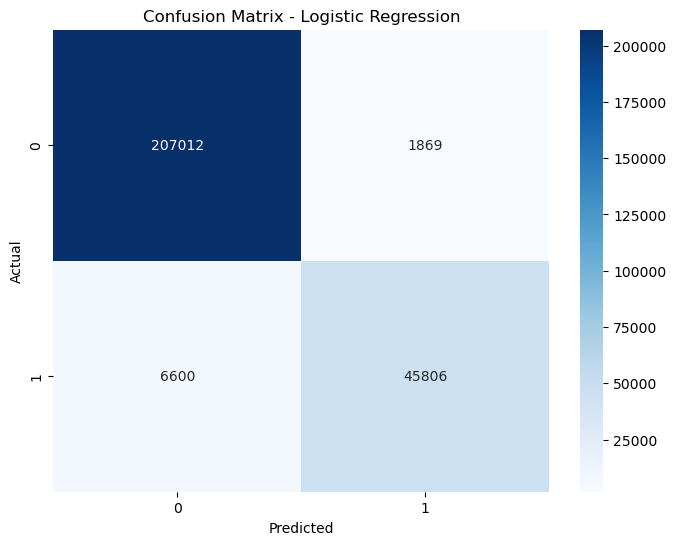

In [72]:
lr_predictions = lr_predictions.select("prediction", "loan_status_binary").toPandas()
plot_confusion_matrix(lr_predictions, "Logistic Regression")

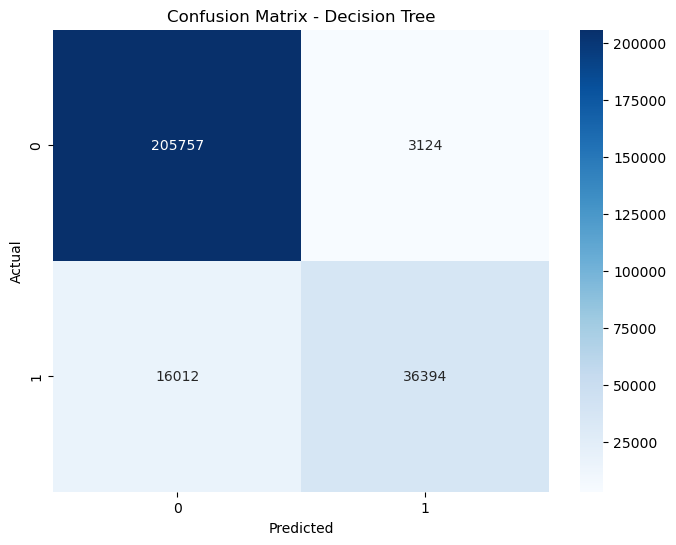

In [73]:
dt_predictions = dt_predictions.select("prediction", "loan_status_binary").toPandas()
plot_confusion_matrix(dt_predictions, "Decision Tree")

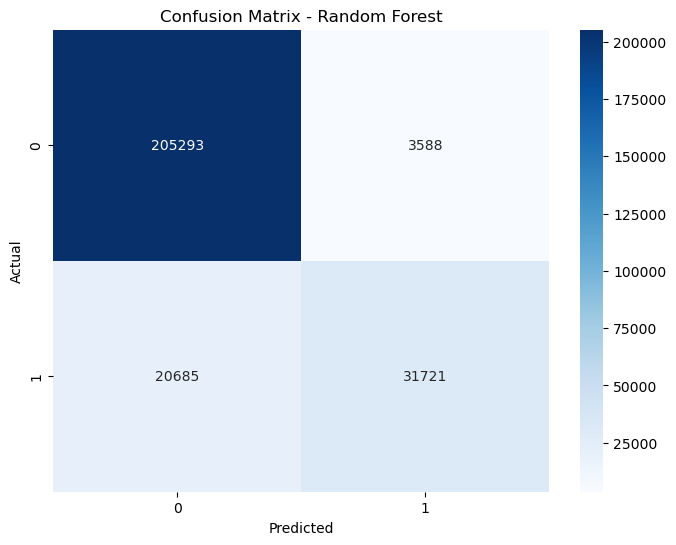

In [74]:
rf_predictions = rf_predictions.select("prediction", "loan_status_binary").toPandas()
plot_confusion_matrix(rf_predictions, "Random Forest")

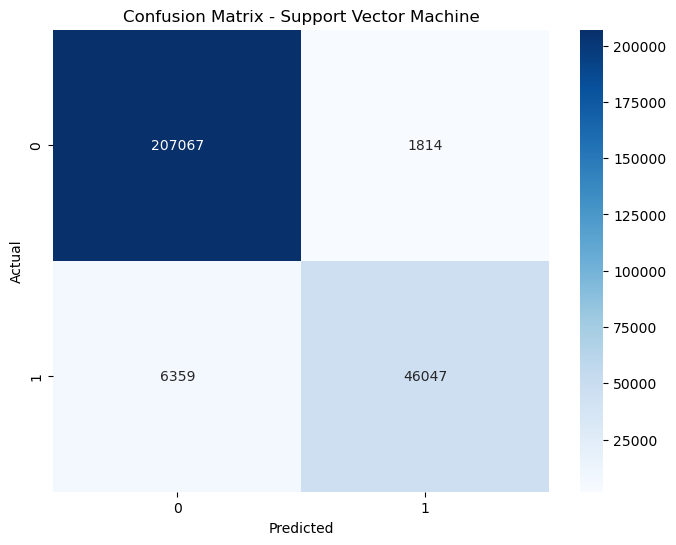

In [75]:
svm_predictions = svm_predictions.select("prediction", "loan_status_binary").toPandas()
plot_confusion_matrix(svm_predictions, "Support Vector Machine")

In [64]:
lr_num_iter = lr_model.summary.totalIterations
print(f"Logistic Regression - Number of iterations: {lr_num_iter}")

Logistic Regression - Number of iterations: 27


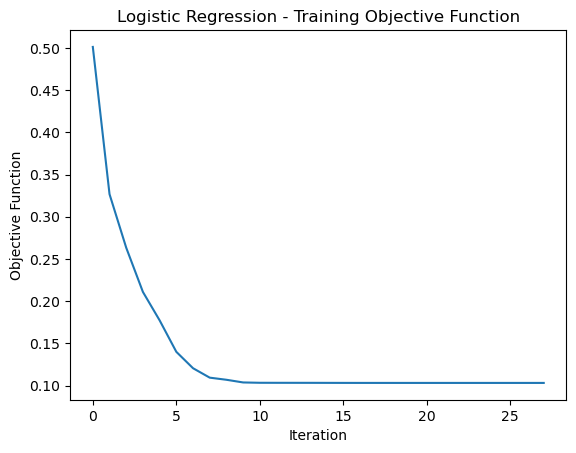

In [47]:
# plot loss of lr model
lr_model_summary = lr_model.summary
plt.plot(lr_model_summary.objectiveHistory)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression - Training Loss')
plt.show()

In [76]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(predictions):
    y_true = predictions['loan_status_binary']
    y_pred = predictions['prediction']
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1_score, accuracy

lr_precision, lr_recall, lr_f1_score, lr_accuracy = compute_metrics(lr_predictions)
dt_precision, dt_recall, dt_f1_score, dt_accuracy = compute_metrics(dt_predictions)
rf_precision, rf_recall, rf_f1_score, rf_accuracy = compute_metrics(rf_predictions)
svm_precision, svm_recall, svm_f1_score, svm_accuracy = compute_metrics(svm_predictions)

print(f"Logistic Regression - Precision: {lr_precision}, Recall: {lr_recall}, F1-Score: {lr_f1_score}, Accuracy: {lr_accuracy}")
print(f"Decision Tree - Precision: {dt_precision}, Recall: {dt_recall}, F1-Score: {dt_f1_score}, Accuracy: {dt_accuracy}")
print(f"Random Forest - Precision: {rf_precision}, Recall: {rf_recall}, F1-Score: {rf_f1_score}, Accuracy: {rf_accuracy}")
print(f"Support Vector Machine - Precision: {svm_precision}, Recall: {svm_recall}, F1-Score: {svm_f1_score}, Accuracy: {svm_accuracy}")


Logistic Regression - Precision: 0.9607970634504457, Recall: 0.8740602221119719, F1-Score: 0.9153785433798624, Accuracy: 0.9675873656171183
Decision Tree - Precision: 0.9209474163672251, Recall: 0.6944624661298324, F1-Score: 0.7918280318523998, Accuracy: 0.926762525498781
Random Forest - Precision: 0.8983828485655215, Recall: 0.6052932870282028, F1-Score: 0.7232742404377814, Accuracy: 0.9071021520397111
Support Vector Machine - Precision: 0.9620985771296044, Recall: 0.8786589321833378, F1-Score: 0.9184876380065226, Accuracy: 0.9687202195287175
